In [30]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)


In [3]:
def get_data_by_variable(variable_id : int) -> pd.DataFrame:
    headers = {
        'format': 'application/json',
        'lang': 'pl',
        'X-ClientId': '54f60e5f-cb69-4b70-fc64-08d9e6308fac',
    }

    query_arguments = {
        'page-size' : '100',
        'unit-level': '5'
    }

    query_string = '&'.join(['='.join([key, value]) for key, value in query_arguments.items()])

    response = requests.get(f'https://bdl.stat.gov.pl/api/v1/data/by-variable/{variable_id}/?{query_string}', headers=headers)
    number_of_records = response.json()['totalRecords']
    data = {}

    for i in range(number_of_records // 100 + 1):
        api_call = requests.get(f'https://bdl.stat.gov.pl/api/v1/data/by-variable/{variable_id}/?{query_string}&page={i}', headers=headers)
        json = api_call.json()

        for result in json['results']:
            years = [row['year'] for row in result['values']]
            values = [row['val'] for row in result['values']]
            data[result['name']] = pd.Series(data=values, index=years)

    return pd.DataFrame.from_dict(data, orient='index')

## Założenia
W przygotowaniu indeksu atrakcyjności lokalizacji dla sklepów i wypożyczalni rowerowych zdecydowałem się na obliczaniu go na poziomie powiatów z uwagi na większą ilość zmiennych statystycznych w BDL na tym poziomie. W swojej analizie skupiam się na dancyh z ostatnich 5 lat (lata 2016-2020).

## Zmienne
nazwa zmiennej [id zmiennej]

### Sport
- kluby sportowe na 10 tys. ludnosci [1609348]

### Zarobki
- przeciętne miesięczne wynagrodzenia brutto w relacji do średniej krajowej (Polska=100) [64429]

### Ludnosc
- gminy bez miast na prawach powiatu ogółem 30.06 [199202]
- gminy bez miast na prawach powiatu ogółem 31.12 [199206]
- miasta na prawach powiatu ogółem 30.06 [199203]
- miasta na prawach powiatu ogółem 31.12 [199207]

Grupy wiekowe
- 0-2 ogółem [453372]
- 3-6 ogółem [453373]
- 7-12 ogółem [453374]
- 13-15 ogółem [453375]
- 16-19 ogółem [453376]
- 20-24 ogółem [453377]
- 25-34 ogółem [453378]
- 35-44 ogółem [453379]
- 45-54 ogółem [453380]
- 55-64 ogółem [453381]
- 65 i więcej ogółem [453382]

### Turystyka
- udzielone noclegi na 1000 ludnosci ogółem [60298]
- turysci korzystający z noclegow na 1000 ludnosci ogółem [60297]

### Transport
- ścieżki rowerowe ogółem [288080]




# Ludność

Dane są aktualizowane co pół roku. Ponadto dane są podzielone na powiaty i miasta na prawach powiatu.

In [4]:
ludnosc_gminy_czerwiec = get_data_by_variable(199202)
ludnosc_miasta_czerwiec = get_data_by_variable(199203)

miasta = ludnosc_miasta_czerwiec.index.to_series().filter(regex='m\\.')
nie_miasta = set(ludnosc_miasta_czerwiec.index).difference(miasta)

ludnosc_gminy_czerwiec.drop(index=miasta, inplace=True)
ludnosc_miasta_czerwiec.drop(index=nie_miasta, inplace=True)

ludnosc_czerwiec = pd.concat([ludnosc_miasta_czerwiec, ludnosc_gminy_czerwiec])

In [5]:
ludnosc_gminy_grudzien = get_data_by_variable(199206)
ludnosc_miasta_grudzien = get_data_by_variable(199207)

ludnosc_gminy_grudzien.drop(index=miasta, inplace=True)
ludnosc_miasta_grudzien.drop(index=nie_miasta, inplace=True)

ludnosc_grudzien = pd.concat([ludnosc_miasta_grudzien, ludnosc_gminy_grudzien])

Różnica między danymi z grudnia i czerwca zmienia się z roku na rok. Nie wygląda na to, żeby to, które dane wybierzemy miało duży wpływ na wyniki. Zdecydowałem się na dane z czerwca.

2011_diff     32.292683
2012_diff     -2.891599
2013_diff    -19.332432
2014_diff    -14.859459
2015_diff    -45.964865
2016_diff     16.862162
2017_diff     28.505405
2018_diff     -6.137838
2019_diff    -11.129730
2020_diff   -237.051351
dtype: float64


<AxesSubplot:>

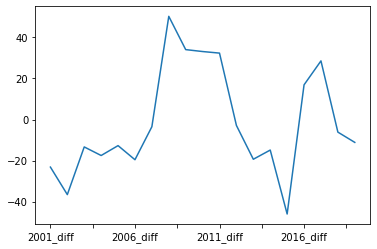

In [6]:
ludnosc_razem = pd.merge(ludnosc_czerwiec, ludnosc_grudzien, left_index=True, right_index=True, suffixes=['_cze', '_gru'])

for year in ludnosc_czerwiec.columns:
    ludnosc_razem[f'{year}_diff'] = ludnosc_razem[f'{year}_gru'] - ludnosc_razem[f'{year}_cze']


srednie_roznice = ludnosc_razem.iloc[:, -20:].agg(np.mean, axis=0)
print(srednie_roznice.iloc[-10:])
srednie_roznice.iloc[:-1].plot(kind='line')

In [7]:
ludnosc_czerwiec = ludnosc_czerwiec.loc[:, '2016':]
ludnosc_czerwiec.dropna(inplace=True)

# Zarobki
Dane obrazują średnie zarobki w powiacie w relacji do średniej krajowej
Jak widać na wykresie średnia płaca przez ostanie 5 lat co roku wzrasta. W związku z tym będziemy brali pod uwagę tylko pensje z roku 2020.

<AxesSubplot:>

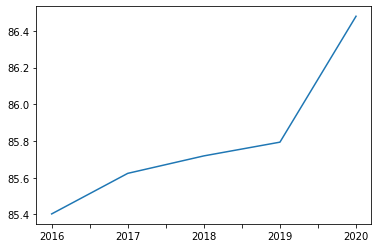

In [8]:
zarobki = get_data_by_variable(64429)
zarobki = zarobki.loc[:, '2016':]
zarobki.dropna(inplace=True)
zarobki.agg(np.mean, axis=0).plot(kind='line')

In [9]:
zarobki_2020 = zarobki.loc[:, '2020']

# Sport

In [10]:
kluby_sportowe = get_data_by_variable(1609348)

In [11]:
kluby_sportowe = kluby_sportowe.loc[:, '2016':]

kluby_lud = pd.merge(ludnosc_czerwiec[kluby_sportowe.columns], kluby_sportowe, left_index=True, right_index=True, suffixes=['_lud', '_ks'])

for year in kluby_sportowe.columns:
    kluby_lud[f'{year}_ogolnie'] = kluby_sportowe[year] * ludnosc_czerwiec[year] / 10_000

W ostatnim roku mial miejsce znaczny spadek liczby klubów sportowych. Jako wyznacznik użyję średnią ilość klubów z ostatnich 5 lat w regionie.

In [12]:
kluby_lud.iloc[:, -3:].agg(np.sum)

2016_ogolnie    14400.11221
2018_ogolnie    14294.23426
2020_ogolnie    13840.66556
dtype: float64

In [13]:
kluby_ogolnie = kluby_lud.iloc[:, -3:].agg(np.mean, axis=1)
kluby_ogolnie = kluby_ogolnie.astype(np.int64)

In [14]:
kluby_sportowe.agg(np.mean, axis=1)

Powiat bocheński                  4.633333
Powiat krakowski                  4.066667
Powiat miechowski                 5.100000
Powiat myślenicki                 5.500000
Powiat proszowicki                2.933333
Powiat wielicki                   4.666667
Powiat m.Kraków                   2.300000
Powiat gorlicki                   6.100000
Powiat limanowski                 5.600000
Powiat nowosądecki                4.333333
Powiat m.Nowy Sącz                5.133333
Powiat chrzanowski                3.033333
Powiat olkuski                    3.866667
Powiat oświęcimski                4.400000
Powiat wadowicki                  4.866667
Powiat brzeski                    4.633333
Powiat dąbrowski                  3.933333
Powiat tarnowski                  4.900000
Powiat m.Tarnów                   3.933333
Powiat nowotarski                 5.233333
Powiat suski                      3.266667
Powiat tatrzański                 5.233333
Powiat bielski                    2.600000
Powiat cies

# Turystyka

In [15]:
udzielone_noclegi = get_data_by_variable(60298)
turysci = get_data_by_variable(60297)

Dla zmiennej udzielone noclegi na 1000 mieszkańców wartości są wyższe, niż dla zmiennej liczba turystówn na 1000 mieszkańców. Pierwsza z nich prawdopodobnie bierze pod uwagę też osoby z danego regionu. Zależy mi na ruchu turystycznym, więc skupię się na drugiej zmiennej.

In [16]:
udzielone_noclegi.head().iloc[:, -10:]

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Powiat bocheński,932.78,827.44,826.89,891.86,895.30,907.85,1007.24,1039.66,1177.21,593.47
Powiat krakowski,486.41,503.22,443.07,445.74,636.70,881.37,863.59,825.19,841.10,344.74
Powiat miechowski,487.48,355.17,306.87,281.99,437.96,1251.99,1236.57,1375.65,1446.15,759.54
Powiat myślenicki,317.90,322.52,335.12,456.64,476.10,622.88,627.23,546.04,578.32,264.40
Powiat proszowicki,199.52,367.89,416.86,345.21,269.56,251.92,242.41,290.54,323.49,96.43


In [17]:
turysci.head().iloc[:, -10:]

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Powiat bocheński,597.29,573.68,492.85,568.83,529.20,543.68,611.13,584.81,718.90,255.16
Powiat krakowski,298.75,322.30,270.40,272.05,394.67,538.34,525.93,516.64,519.31,198.84
Powiat miechowski,293.99,238.27,217.27,198.66,263.63,627.51,627.91,696.05,696.82,332.19
Powiat myślenicki,124.35,137.19,145.22,208.58,234.22,293.38,312.68,304.96,303.87,145.22
Powiat proszowicki,115.53,250.98,292.92,274.98,214.33,162.92,139.51,167.75,196.74,62.40


In [18]:
turysci = turysci.loc[:, '2016':]
turysci.dropna(inplace=True)

In [19]:
turysci_ogolem = pd.DataFrame()

for year in turysci.columns:
    turysci_ogolem[year] = turysci[year] * ludnosc_czerwiec[year] / 1000

In [20]:
turysci_ogolem.agg(np.sum).astype(np.int64)

2016    29357805
2017    31203254
2018    33067150
2019    34811620
2020    17351127
dtype: int64

Widać duży spadek w 2020 roku. Jako wyznacznika użyjemy średniej z ostatnich 5 lat.

In [21]:
turysci_srednia = turysci_ogolem.agg(np.mean, axis=1)
turysci_srednia = turysci_srednia.astype(np.int64)

# Transport
Tutaj interesują nas tylko dane z 2020 roku.

In [22]:
sciezki_rowerowe = get_data_by_variable(288080)
sciezki_rowerowe = sciezki_rowerowe['2020']

In [23]:
sciezki_rowerowe.head(10)

Powiat bocheński       28.5
Powiat krakowski       25.1
Powiat miechowski      14.3
Powiat myślenicki      12.5
Powiat proszowicki      0.2
Powiat wielicki        11.9
Powiat m.Kraków       252.8
Powiat gorlicki        22.4
Powiat limanowski       2.0
Powiat nowosądecki     44.3
Name: 2020, dtype: float64

# Budowanie indeksów

In [24]:
dane = {
    'ludnosc' : ludnosc_czerwiec['2020'].astype(np.int64),
    'turysci_1k_mieszkancow': turysci.agg(np.sum, axis=1),
    'turysci_ogolem': turysci_srednia,
    'kluby_sportowe_10k_mieszkancow': kluby_sportowe.agg(np.mean, axis=1),
    'kluby_sportowe_ogolem': kluby_ogolnie,
    'zarobki': zarobki_2020,
    'sciezki_rowerowe': sciezki_rowerowe
}

dane_razem = pd.DataFrame(dane)

In [25]:
dane_razem

,ludnosc,turysci_1k_mieszkancow,turysci_ogolem,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat aleksandrowski,55007,13489.56,149020,4.133333,22,74.9,27.4
Powiat augustowski,57908,5484.42,64166,4.100000,23,90.7,57.1
Powiat bartoszycki,56891,1281.92,14895,2.433333,14,83.1,16.2
Powiat bełchatowski,112702,2279.32,51469,4.666667,52,126.8,137.0
Powiat bialski,110454,3641.75,81273,3.233333,36,77.1,53.6
Powiat białobrzeski,33332,917.01,6147,3.100000,10,79.9,10.6
Powiat białogardzki,47434,550.62,5298,3.466667,16,84.6,25.8
Powiat białostocki,150333,1973.05,58179,3.833333,56,80.7,136.2
Powiat bielski,54058,1304.59,14478,2.600000,14,100.4,32.6
Powiat bieruńsko-lędziński,59864,966.06,11475,3.566667,21,84.2,38.0


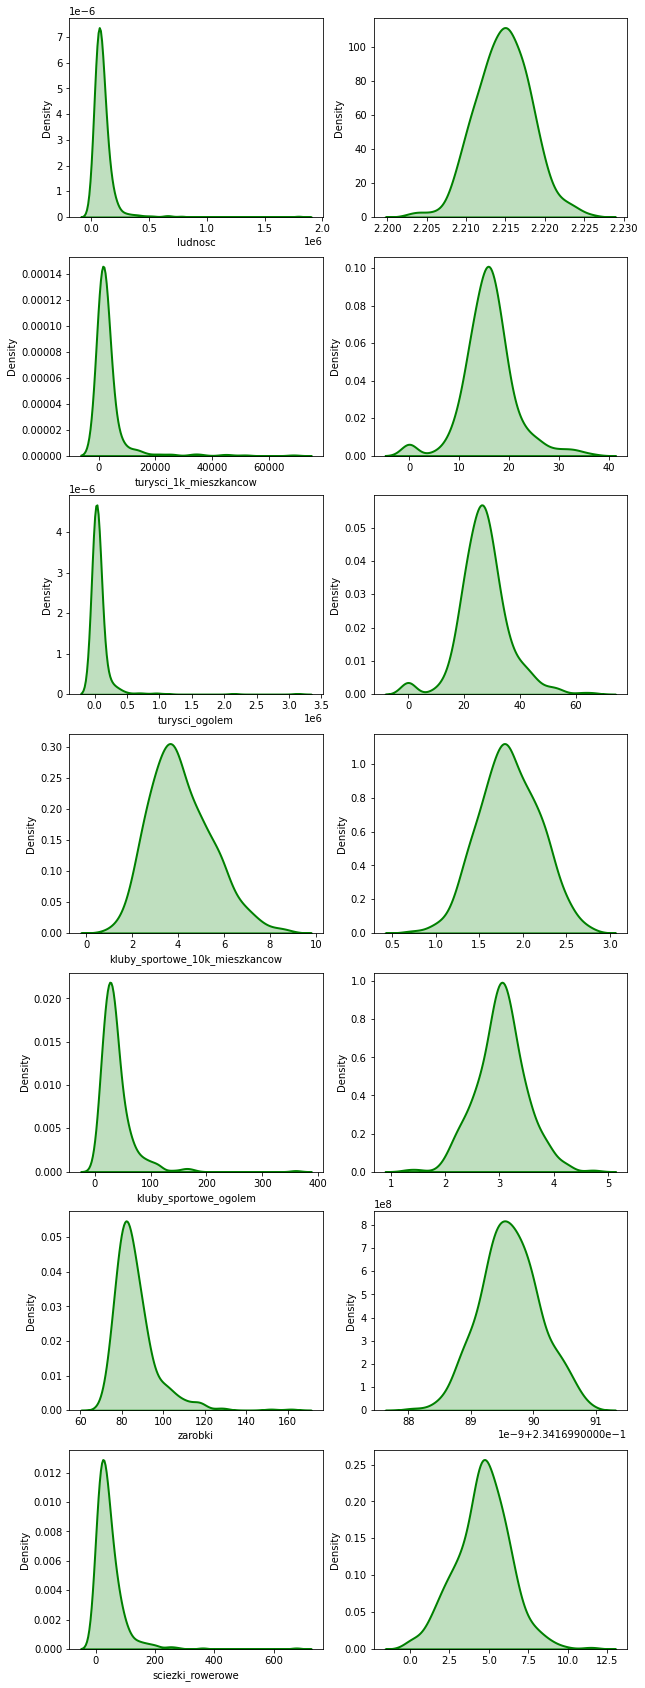

In [54]:
import warnings
from scipy.stats import boxcox


fig, ax = plt.subplots(dane_razem.columns.size, 2)

with warnings.catch_warnings(record=True):
    for i, col in enumerate(dane_razem.columns):
        sns.distplot(dane_razem[col], hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 color='green',
                 label=col,
                 ax=ax[i, 0]
                 )

        sns.distplot(boxcox(dane_razem[col] + 1)[0], hist=False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2},
                     color='green',
                     label=col,
                     ax=ax[i, 1]
                     )


fig.set_figwidth(10)
fig.set_figheight(30)

In [72]:
dane_norm = pd.DataFrame(index=dane_razem.index)

for col in dane_razem.columns:
    dane_standard = dane_razem[col].transform(lambda x: (x - x.min())/(x.max() - x.min()))
    dane_norm[col] = boxcox(dane_standard + 1)[0]
    dane_norm[col] = dane_norm[col].transform(lambda x: (x - x.min())/(x.max() - x.min()))

dane_norm

,ludnosc,turysci_1k_mieszkancow,turysci_ogolem,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat aleksandrowski,0.322493,0.962124,0.804429,0.565263,0.382832,0.248271,0.366196
Powiat augustowski,0.343665,0.753988,0.509322,0.560808,0.397910,0.683991,0.605760
Powiat bartoszycki,0.336323,0.286497,0.153430,0.301554,0.246021,0.526257,0.237984
Powiat bełchatowski,0.636285,0.448968,0.435732,0.633375,0.698297,0.949190,0.879922
Powiat bialski,0.627497,0.610587,0.593173,0.435676,0.560983,0.337818,0.583490
Powiat białobrzeski,0.139724,0.215030,0.066519,0.414681,0.165293,0.434695,0.163525
Powiat białogardzki,0.263773,0.135635,0.057609,0.471233,0.283117,0.563318,0.349410
Powiat białostocki,0.755083,0.403697,0.475938,0.524262,0.724697,0.459335,0.878554
Powiat bielski,0.315413,0.290704,0.149482,0.331191,0.246021,0.807282,0.417579
Powiat bieruńsko-lędziński,0.357547,0.225061,0.120488,0.486030,0.367336,0.553764,0.466187


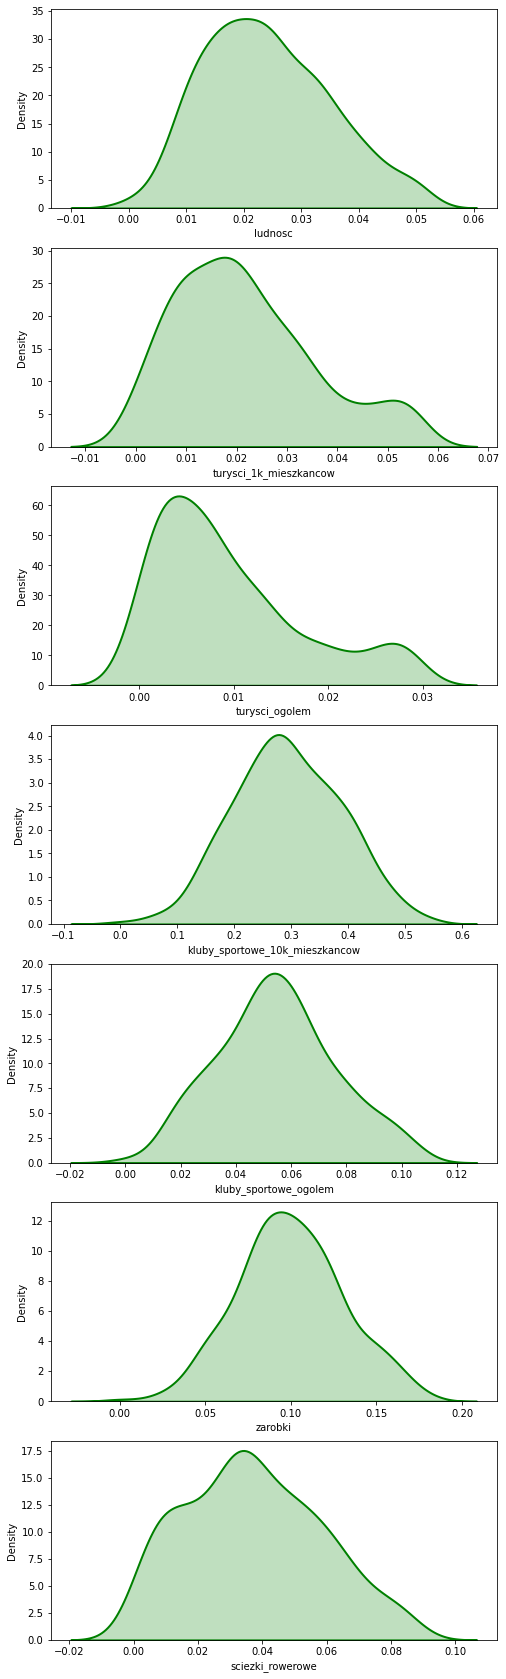

In [61]:
import warnings
from scipy.stats import boxcox


fig, ax = plt.subplots(dane_norm.columns.size)

with warnings.catch_warnings(record=True):
    for i, col in enumerate(dane_norm.columns):
        sns.distplot(dane_norm[col], hist=False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2},
                     color='green',
                     label=col,
                     ax=ax[i]
                     )

fig.set_figwidth(8)
fig.set_figheight(30)

<AxesSubplot:ylabel='Frequency'>

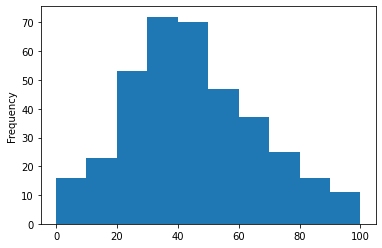

In [105]:
wypozyczalnie = ((2 * dane_norm.turysci_1k_mieszkancow + dane_norm.sciezki_rowerowe + 1.2 - dane_norm.zarobki)).transform(lambda x: (x - x.min())/ (x.max() - x.min())) * 100
wypozyczalnie.sort_values(ascending=False).plot(kind='hist')



In [106]:
top10_wypozyczalni = wypozyczalnie.nlargest(10).index
dane_norm.loc[top10_wypozyczalni, :]

,ludnosc,turysci_1k_mieszkancow,turysci_ogolem,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat pucki,0.522243,0.991948,0.976616,0.533552,0.528219,0.590629,0.838691
Powiat kamieński,0.259118,0.999227,0.964046,0.872146,0.516705,0.367305,0.552119
Powiat kołobrzeski,0.480407,0.999881,0.999135,0.582844,0.528219,0.518427,0.671302
Powiat sławieński,0.329893,0.980066,0.867642,0.696027,0.480260,0.398702,0.569475
Powiat koszaliński,0.402162,0.980729,0.907416,0.645517,0.504880,0.538990,0.665676
Powiat nowotarski,0.840304,0.815708,0.936009,0.699777,0.894172,0.388438,0.818200
Powiat aleksandrowski,0.322493,0.962124,0.804429,0.565263,0.382832,0.248271,0.366196
Powiat nowosądecki,0.876133,0.894194,0.983274,0.591492,0.877492,0.265537,0.517396
Powiat gryficki,0.358676,0.992844,0.938537,0.637444,0.467446,0.421898,0.468755
Powiat słupski,0.578135,0.908125,0.872628,0.524262,0.571339,0.572642,0.752028


In [108]:
sklepy = (dane_norm.ludnosc + dane_norm.sciezki_rowerowe + 2 * dane_norm.zarobki + dane_norm.kluby_sportowe_10k_mieszkancow).transform(lambda x: (x - x.min())/ (x.max() - x.min())) * 100
sklepy#.plot(kind='hist')

Powiat aleksandrowski              20.485223
Powiat augustowski                 58.041012
Powiat bartoszycki                 26.409059
Powiat bełchatowski                96.996493
Powiat bialski                     39.527666
Powiat białobrzeski                15.051117
Powiat białogardzki                35.822892
Powiat białostocki                 64.646700
Powiat bielski                     51.398237
Powiat bieruńsko-lędziński         42.691198
Powiat bieszczadzki                17.905289
Powiat biłgorajski                 50.912671
Powiat bocheński                   49.058581
Powiat bolesławiecki               60.345216
Powiat braniewski                  13.124792
Powiat brodnicki                   25.790824
Powiat brzeski                     52.764131
Powiat brzeziński                   7.431180
Powiat brzozowski                  32.969714
Powiat buski                       26.190483
Powiat bydgoski                    76.407260
Powiat bytowski                    65.658536
Powiat będ

In [28]:
wypozyczalnie = (dane_razem.kluby_sportowe * dane_razem.sciezki_rowerowe * dane_razem.sciezki_rowerowe).transform(lambda x: (x - x.min())/ (x.max() - x.min())) * 100

wypozyczalnie = pd.Series(boxcox(wypozyczalnie + 1)[0], index=wypozyczalnie.index)

AttributeError: 'DataFrame' object has no attribute 'kluby_sportowe'

In [ ]:
wypozyczalnie = wypozyczalnie * 100
wypozyczalnie.sort_values(ascending=False)
plt.hist(wypozyczalnie)
plt.show()

In [ ]:
zarobki_norm = (dane_razem.zarobki - dane_razem.zarobki.min()) / (dane_razem.zarobki.max() - dane_razem.zarobki.min())
zarobki_norm.sort_values()

dane_razem.zarobki.transform(lambda x: (x - x.min())/ (x.max() - x.min())).sort_values()

In [ ]:
dane_razem.zarobki.min()

In [ ]:
from scipy.stats import boxcox
import seaborn as sns

vek = turysci.agg(np.mean, axis=1)#.sort_values().plot(kind='hist')
# vek.plot(kind='hist')
# vek[vek < 1000].size #.plot(kind='box')
vek = vek.transform(lambda x: (x - x.min())/ (x.max() - x.min()))
norm = boxcox(vek + 1)[0]
plt.hist(norm)

In [ ]:
vek2 = pd.Series(boxcox(vek + 1)[0], index=vek.index)
vek2.sort_values(ascending=False)

for i1, i2 in zip(vek2.sort_values(ascending=False).index, vek.sort_values(ascending=False).index):
    if i1 != i2:
        print('hey')